In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-student-performance-from-game-play/sample_submission.csv
/kaggle/input/predict-student-performance-from-game-play/train_labels.csv
/kaggle/input/predict-student-performance-from-game-play/train.csv
/kaggle/input/predict-student-performance-from-game-play/test.csv
/kaggle/input/predict-student-performance-from-game-play/jo_wilder/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/predict-student-performance-from-game-play/jo_wilder/__init__.py


# Introduction:
The dataset is provided by The Learning Agency Lab

I chose this competition for several reasons. Firstly, it offers the opportunity to develop a model trained on one of the largest open datasets of game logs. Secondly, this competition is hosted by Field Day lab, a publicly funded research lab, which adds credibility to the dataset. Thirdly, this is a new dataset made available by The Learning Agency Lab, meaning that my project work with this dataset will be novel. Additionally, there is a 3-month time frame to complete the competition, which provides ample time to complete the project work.

I also believe that this competition will have a significant social impact as it will benefit developers of educational games by allowing them to create more effective learning experiences for students. Furthermore, educators will be able to use games with dashboards and analytic tools to support students.

Lastly, participating in this competition will also be a great opportunity for me to learn and grow as a deep learning practitioner. I will be ranked based on my model performance, which will give me an idea of my level in deep learning and provide valuable feedback for future projects.

## Problem Statement:

Knowledge tracing methods have been developed and studied in the context of online learning environments and intelligent tutoring systems,but there is insufficient use of knowledge tracing methods in most game-based learning platforms to support individual students. The objective is to develop a model that can improve the use of knowledge tracing methods in game-based learning platforms and support individual students to enhance their learning experience.The aim of this model is to predict student performance during game-based learning in real-time.



In [2]:
## Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam

#warnings.simplefilter("ignore")
sns.set_style("darkgrid")
pd.options.display.max_rows = None
pd.options.display.max_columns = None
colors = sns.color_palette("Set2")
print("Setup is complete!")








Setup is complete!


## Load the data

In [3]:
# save filepath to variable for easier access
file_path = '../input/predict-student-performance-from-game-play'
dtypes={'session_id':'category', 
'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'page':'category',
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
     'text':'category',
     'fqid':'category',
     'room_fqid':'category',
     'text_fqid':'category',
     'fullscreen':'category',
     'hq':'category',
     'music':'category',
     'level_group':'category'}
student_train_data=pd.read_csv(f'{file_path}/train.csv', dtype=dtypes)


# read the data and store data in DataFrame titled student_train_data
#student_train_data = pd.read_csv(f'{file_path}/train.csv')
student_test_data = pd.read_csv(f'{file_path}/test.csv')
student_train_labels_data = pd.read_csv(f'{file_path}/train_labels.csv')                                


## Understand the data

In [4]:
print("\033[31mInformation about train data\033[0m\n")
print(student_train_data.info())
print("\033[31mInformation about test data\033[0m\n")
print(student_test_data.info())
print("\033[31mInformation about train_labels data\033[0m\n")
print(student_train_labels_data.info())

Information about train data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26296946 entries, 0 to 26296945
Data columns (total 20 columns):
 #   Column          Dtype   
---  ------          -----   
 0   session_id      category
 1   index           int64   
 2   elapsed_time    int32   
 3   event_name      category
 4   name            category
 5   level           uint8   
 6   page            category
 7   room_coor_x     float32 
 8   room_coor_y     float32 
 9   screen_coor_x   float32 
 10  screen_coor_y   float32 
 11  hover_duration  float32 
 12  text            category
 13  fqid            category
 14  room_fqid       category
 15  text_fqid       category
 16  fullscreen      category
 17  hq              category
 18  music           category
 19  level_group     category
dtypes: category(12), float32(5), int32(1), int64(1), uint8(1)
memory usage: 1.2 GB
None
Information about test data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3728 entries, 0 to 3727
Dat

### Description of the variables (copied from dataset description)
* session_id - the ID of the session the event took place in
* index - the index of the event for the session
* elapsed_time - how much time has passed (in milliseconds) between the start of the session and when the event was recorded
* event_name - the name of the event type
* name - the event name (e.g. identifies whether a notebook_click is is opening or closing the notebook). It's values can be either of these:
    * cutscene_click 
    * person_click
    * navigate_click
    * observation_click
    * notification_click
    * object_click
    * object_hover
    * map_hover
    * map_click
    * checkpoint
    * notebook_click
* level - what level of the game the event occurred in (0 to 22)
* page - the page number of the event (only for notebook-related events)
* room_coor_x - the coordinates of the click in reference to the in-game room (only for click events)
* room_coor_y - the coordinates of the click in reference to the in-game room (only for click events)
* screen_coor_x - the coordinates of the click in reference to the player’s screen (only for click events)
* screen_coor_y - the coordinates of the click in reference to the player’s screen (only for click events)
* hover_duration - how long (in milliseconds) the hover happened for (only for hover events)
* text - the text the player sees during this event
* fqid - the fully qualified ID of the event
* room_fqid - the fully qualified ID of the room the event took place in
* text_fqid - the fully qualified ID of the
* fullscreen - whether the player is in fullscreen mode
* hq - whether the game is in high-quality
* music - whether the game music is on or off
* level_group - which group of levels - and group of questions - this row belongs to (0-4, 5-12, 13-22)

### Sample Data Preview

In [5]:
student_train_data.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991394,-159.314682,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [6]:
student_train_data.tail()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
26296941,22100221145014656,1600,5483231,navigate_click,undefined,22,NaN,343.887299,36.701027,483.0,273.0,NaN,NaN,NaN,tunic.capitol_2.hall,NaN,0,0,1,13-22
26296942,22100221145014656,1601,5485166,navigate_click,undefined,22,NaN,332.696075,141.493179,545.0,221.0,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,0,0,1,13-22
26296943,22100221145014656,1602,5485917,navigate_click,undefined,22,NaN,369.912872,140.569199,611.0,217.0,NaN,NaN,NaN,tunic.capitol_2.hall,NaN,0,0,1,13-22
26296944,22100221145014656,1603,5486753,navigate_click,undefined,22,NaN,252.299652,123.805893,526.0,232.0,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,0,0,1,13-22
26296945,22100221145014656,1604,5487952,checkpoint,basic,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,0,0,1,13-22


In [7]:
student_test_data.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,session_level
0,20090109393214576,0,0,cutscene_click,basic,0,NaN,-413.991405,75.685314,380.0,259.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4,0
1,20090109393214576,1,1965,person_click,basic,0,NaN,-105.991405,-63.314686,688.0,398.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,0
2,20090109393214576,2,3614,person_click,basic,0,NaN,-418.991405,47.685314,375.0,287.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,0
3,20090109393214576,3,5330,person_click,basic,0,NaN,-110.991405,-57.314686,683.0,392.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,0
4,20090109393214576,4,6397,person_click,basic,0,NaN,-110.991405,-57.314686,683.0,392.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,0


In [8]:
student_test_data.tail()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,session_level
3723,20090312331414616,1001,1581679,map_hover,basic,22,NaN,NaN,NaN,NaN,NaN,484.0,NaN,tunic.wildlife,tunic.historicalsociety.entry,NaN,0,0,1,13-22,8
3724,20090312331414616,1002,1583044,map_hover,basic,22,NaN,NaN,NaN,NaN,NaN,783.0,NaN,tunic.capitol_2,tunic.historicalsociety.entry,NaN,0,0,1,13-22,8
3725,20090312331414616,1003,1583410,map_click,undefined,22,NaN,483.726363,-3.880047,456.0,332.0,NaN,NaN,tunic.capitol_2,tunic.historicalsociety.entry,NaN,0,0,1,13-22,8
3726,20090312331414616,1004,1585841,navigate_click,undefined,22,NaN,192.372139,38.216178,383.0,272.0,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,0,0,1,13-22,8
3727,20090312331414616,1005,1587810,checkpoint,basic,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,0,0,1,13-22,8


In [9]:
student_train_labels_data.head()

,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090312455206810_q1,1
3,20090313091715820_q1,0
4,20090313571836404_q1,1


In [10]:
student_train_labels_data.tail()

,session_id,correct
424111,22100215342220508_q18,1
424112,22100215460321130_q18,1
424113,22100217104993650_q18,1
424114,22100219442786200_q18,1
424115,22100221145014656_q18,1


### Shape of Data

In [11]:
train_num_rows, train_num_cols = student_train_data.shape
print(f'student_train_data \nNumber of rows : {train_num_rows}\nNumber of columns: {train_num_cols}')

student_train_data 
Number of rows : 26296946
Number of columns: 20


* There are more than 26 million instances/observaions of data with 20 varaibles.

In [12]:
test_num_rows, test_num_cols = student_test_data.shape
print(f'student_test_data \nNumber of rows : {test_num_rows}\nNumber of columns: {test_num_cols}')

student_test_data 
Number of rows : 3728
Number of columns: 21


* There are 3728 instances in the test data with 21 variables. This datset has 1 extra variable called "session_level" which is defined as:

|level group |session_level|
|:-----------|------------:|
|0-4         | 0           |
|5-12        |1            |
|13-22       |2            |


In [13]:
train_labels_num_rows, train_labels_num_cols = student_train_labels_data.shape
print(f'student_train_labels_data \nNumber of rows : {train_labels_num_rows}\nNumber of columns: {train_labels_num_cols}')

student_train_labels_data 
Number of rows : 424116
Number of columns: 2


In [14]:
# get unique values from each column
for col in student_train_data.columns:
    unique_values = student_train_data[col].unique()
    print(f"Unique values in column '{col}': {unique_values}")

Unique values in column 'session_id': ['20090312431273200', '20090312433251036', '20090312455206810', '20090313091715820', '20090313571836404', ..., '22100215342220508', '22100215460321130', '22100217104993650', '22100219442786200', '22100221145014656']
Length: 23562
Categories (23562, object): ['20090312431273200', '20090312433251036', '20090312455206810', '20090313091715820', ..., '22100215460321130', '22100217104993650', '22100219442786200', '22100221145014656']
Unique values in column 'index': [    0     1     2 ... 20471 20472 20473]
Unique values in column 'elapsed_time': [      0    1323     831 ... 5485166 5486753 5487952]
Unique values in column 'event_name': ['cutscene_click', 'person_click', 'navigate_click', 'observation_click', 'notification_click', ..., 'object_hover', 'map_hover', 'map_click', 'checkpoint', 'notebook_click']
Length: 11
Categories (11, object): ['checkpoint', 'cutscene_click', 'map_click', 'map_hover', ..., 'object_click', 'object_hover', 'observation_cli

In [15]:
# print a summary of the data in student_train_data
student_train_data.describe()

,index,elapsed_time,level,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration
count,2.629695e+07,2.629695e+07,2.629695e+07,2.422367e+07,2.422367e+07,2.422367e+07,2.422367e+07,2.002244e+06
mean,6.445102e+02,4.016694e+06,1.219169e+01,-5.490582e+01,-1.162119e+02,4.584099e+02,3.855858e+02,3.471006e+03
std,5.457880e+02,3.127032e+07,6.497789e+00,5.202926e+02,2.184710e+02,2.479389e+02,1.298166e+02,4.602024e+05
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.992355e+03,-9.181624e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.880000e+02,4.397000e+05,6.000000e+00,-3.528395e+02,-2.127183e+02,2.690000e+02,3.040000e+02,9.900000e+01
50%,5.950000e+02,1.014801e+06,1.300000e+01,-1.116280e+01,-9.760534e+01,4.470000e+02,3.970000e+02,4.190000e+02
75%,8.960000e+02,1.747040e+06,1.800000e+01,2.966515e+02,2.268786e+01,6.630000e+02,4.710000e+02,1.266000e+03
max,2.047300e+04,1.988607e+09,2.200000e+01,1.261774e+03,5.436164e+02,1.919000e+03,1.440000e+03,2.451637e+08


In [16]:
# print a summary of the data in student_test_data
student_test_data.describe()

,session_id,index,elapsed_time,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,fullscreen,hq,music,session_level
count,3.728000e+03,3728.000000,3.728000e+03,3728.000000,153.000000,3366.000000,3366.000000,3366.000000,3366.000000,353.000000,3728.0,3728.0,3728.0,3728.000000
mean,2.009024e+16,670.427039,2.065026e+06,12.171137,3.405229,-14.706281,-131.060856,463.707665,394.447415,1415.631728,0.0,0.0,1.0,4.135730
std,9.599042e+10,411.203747,2.079750e+06,6.282262,2.037277,511.111044,224.031904,243.673841,133.453547,2664.616915,0.0,0.0,0.0,2.423131
min,2.009011e+16,0.000000,0.000000e+00,0.000000,0.000000,-1913.116237,-908.325270,0.000000,10.000000,15.000000,0.0,0.0,1.0,0.000000
25%,2.009011e+16,320.000000,5.708750e+05,7.000000,2.000000,-290.094620,-232.803150,278.250000,320.250000,83.000000,0.0,0.0,1.0,2.000000
50%,2.009031e+16,642.000000,1.174912e+06,11.000000,4.000000,16.843882,-109.000000,460.000000,408.000000,416.000000,0.0,0.0,1.0,4.000000
75%,2.009031e+16,983.250000,2.481634e+06,18.000000,5.000000,355.095522,1.006296,680.000000,486.000000,1316.000000,0.0,0.0,1.0,6.000000
max,2.009031e+16,1563.000000,6.524025e+06,22.000000,6.000000,1214.941972,489.514956,879.000000,658.000000,23451.000000,0.0,0.0,1.0,8.000000


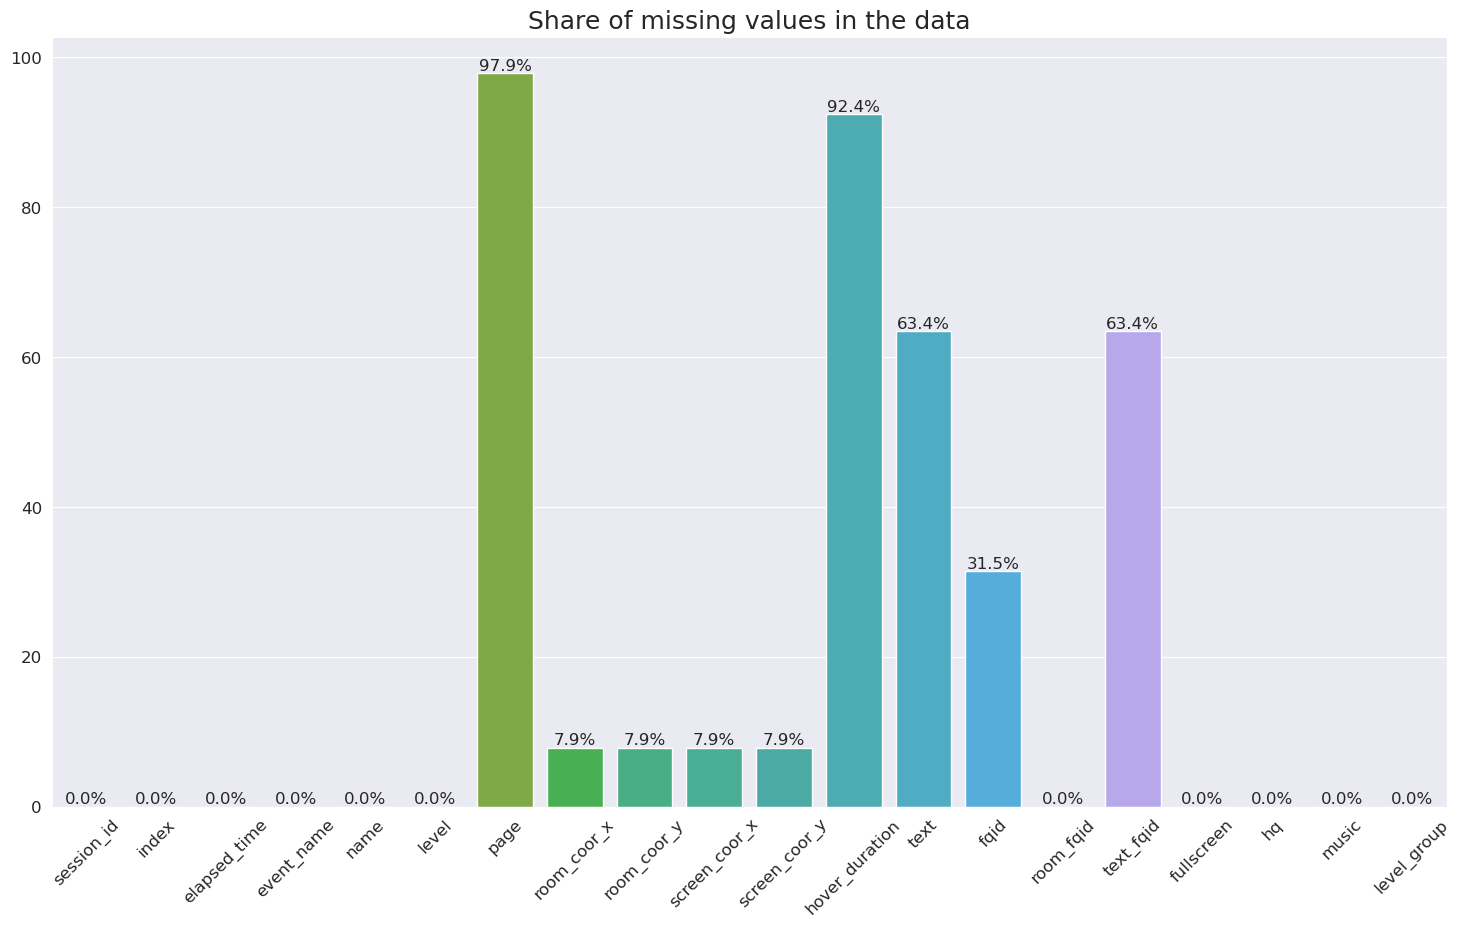

In [17]:
train_missing = student_train_data.isna().sum() / len(student_train_data) *100
train_missing_index = train_missing.index
train_missing_values = train_missing.values

fig, ax = plt.subplots(figsize=(18, 10))
barchart = sns.barplot(x = train_missing_index, y = train_missing_values, ax = ax)
barchart.axes.set_title("Share of missing values in the data", fontsize=18, loc = 'center')
barchart.bar_label(barchart.containers[0], fmt="%.1f%%", fontsize=12)
barchart.yaxis.set_tick_params(labelsize = 12)
barchart.xaxis.set_tick_params(rotation=45, labelsize = 12)
plt.show()

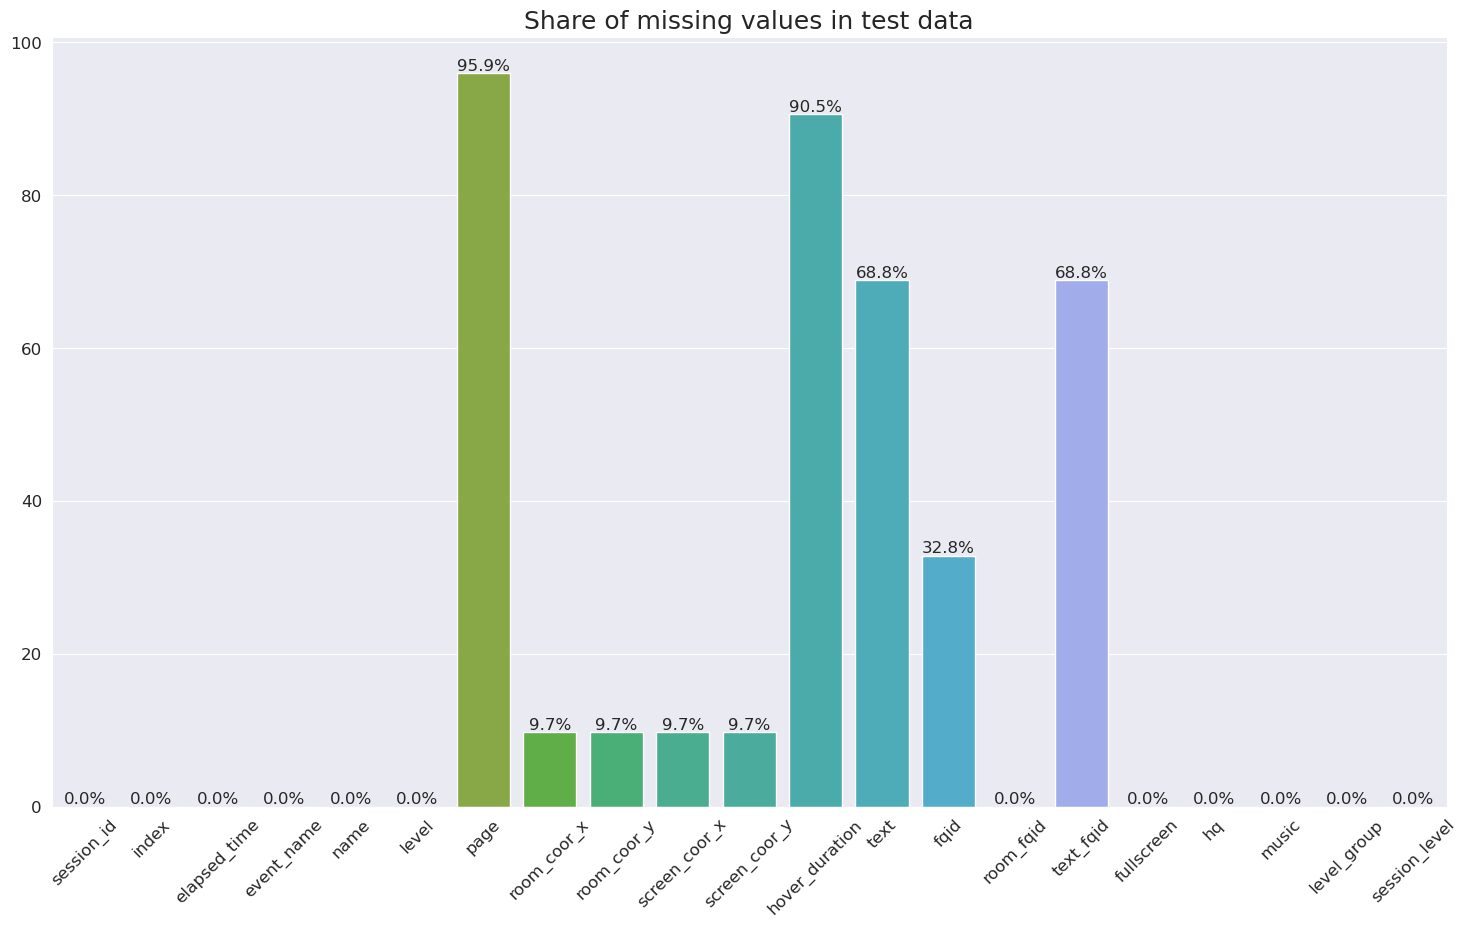

In [18]:
test_missing = student_test_data.isna().sum() / len(student_test_data) *100
test_missing_index = test_missing.index
test_missing_values = test_missing.values

fig, ax = plt.subplots(figsize=(18, 10))
barchart = sns.barplot(x = test_missing_index, y = test_missing_values, ax = ax)
barchart.axes.set_title("Share of missing values in test data", fontsize=18, loc = 'center')
barchart.bar_label(barchart.containers[0], fmt="%.1f%%", fontsize=12)
barchart.yaxis.set_tick_params(labelsize = 12)
barchart.xaxis.set_tick_params(rotation=45, labelsize = 12)
plt.show()

In [19]:
## performance_features = ['elapsed_time', 'level', 'room_coor_x', 'room_coor_y', 'hover_duration', 'music']

In [20]:
# selected_features = ['elapsed_time', 'level', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y','room_fqid', 'fullscreen', 'hq', 'music','level_group']
selected_features = ['index', 'elapsed_time', 'level']

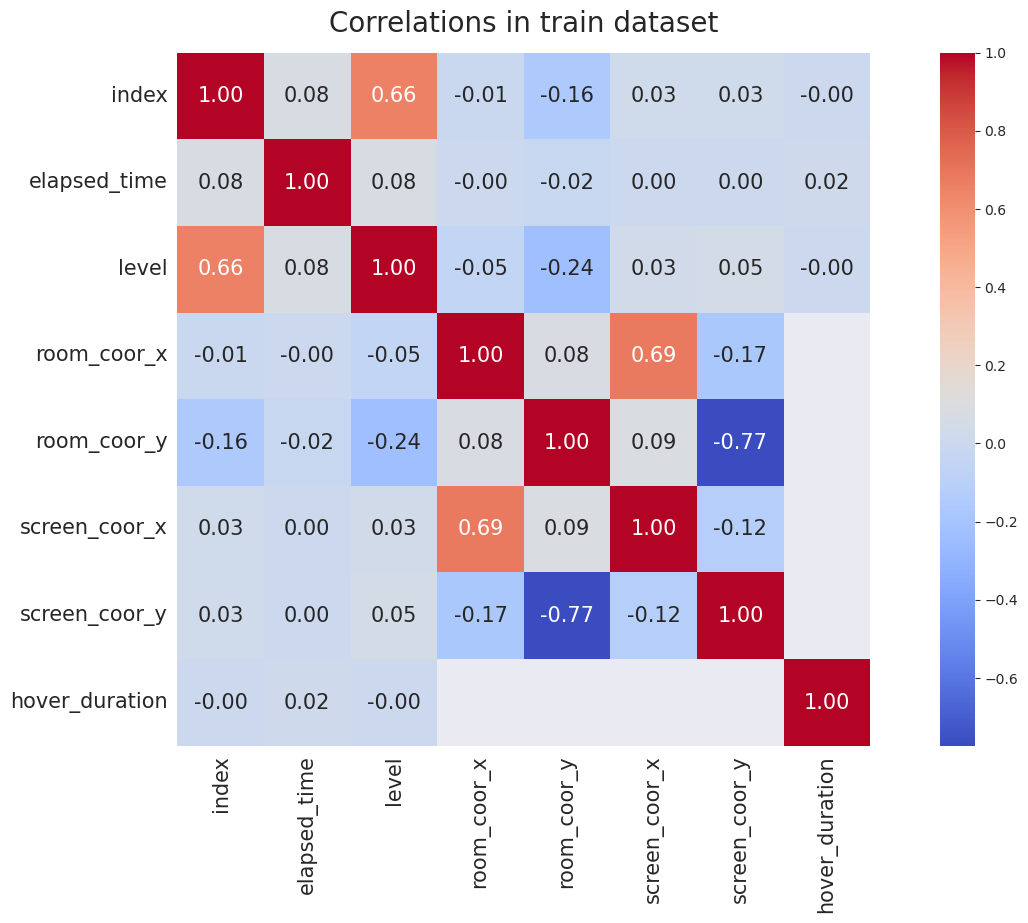

In [21]:
plt.figure(figsize=(18, 9))
g = sns.heatmap(student_train_data.corr(), annot=True, square=True, cmap='coolwarm', annot_kws={'size': 15},fmt='.2f')
g.tick_params(axis='x', labelsize=15)
g.tick_params(axis='y', labelsize=15)
g.set_title('Correlations in train dataset', size=20, pad=15)
plt.show()

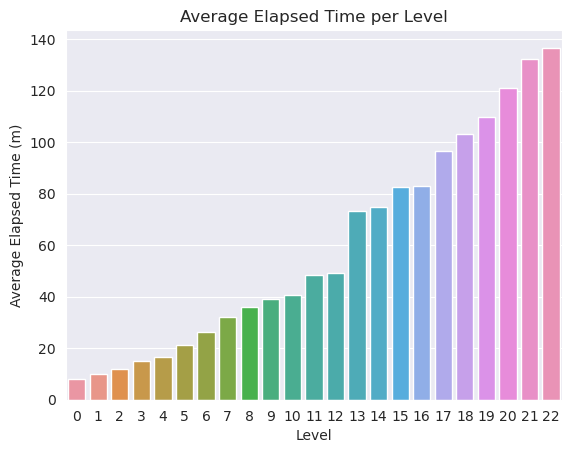

In [22]:
# Group the data by level and calculate the mean of elapsed_time
avg_elapsed_time = student_train_data.groupby('level')['elapsed_time'].mean()/60000

# Create the barplot
sns.barplot(x=avg_elapsed_time.index, y=avg_elapsed_time.values)
plt.xlabel('Level')
plt.ylabel('Average Elapsed Time (m)')
plt.title('Average Elapsed Time per Level')
plt.show()


In [23]:
elapsed_time_train = np.round((student_train_data['elapsed_time']).astype(np.float64)/60000.0, 1)
elapsed_time_test = np.round((student_test_data['elapsed_time']).astype(np.float64)/60000.0, 1)

stat = pd.DataFrame([elapsed_time_train.describe().index,
                    np.round(elapsed_time_train.describe(), 2).values,
                    np.round(elapsed_time_test.describe(), 2).values]).T
stat.columns = [' ', 'train', 'test']
stat[['train', 'test']] = stat[['train', 'test']].astype(np.float64)
print('The statistics of `elapsed_time` column:')
stat[1:].style.hide_index().format(precision=1).background_gradient()


The statistics of `elapsed_time` column:


,train,test
mean,66.9,34.4
std,521.2,34.7
min,0.0,0.0
25%,7.3,9.5
50%,16.9,19.6
75%,29.1,41.4
max,33143.4,108.7


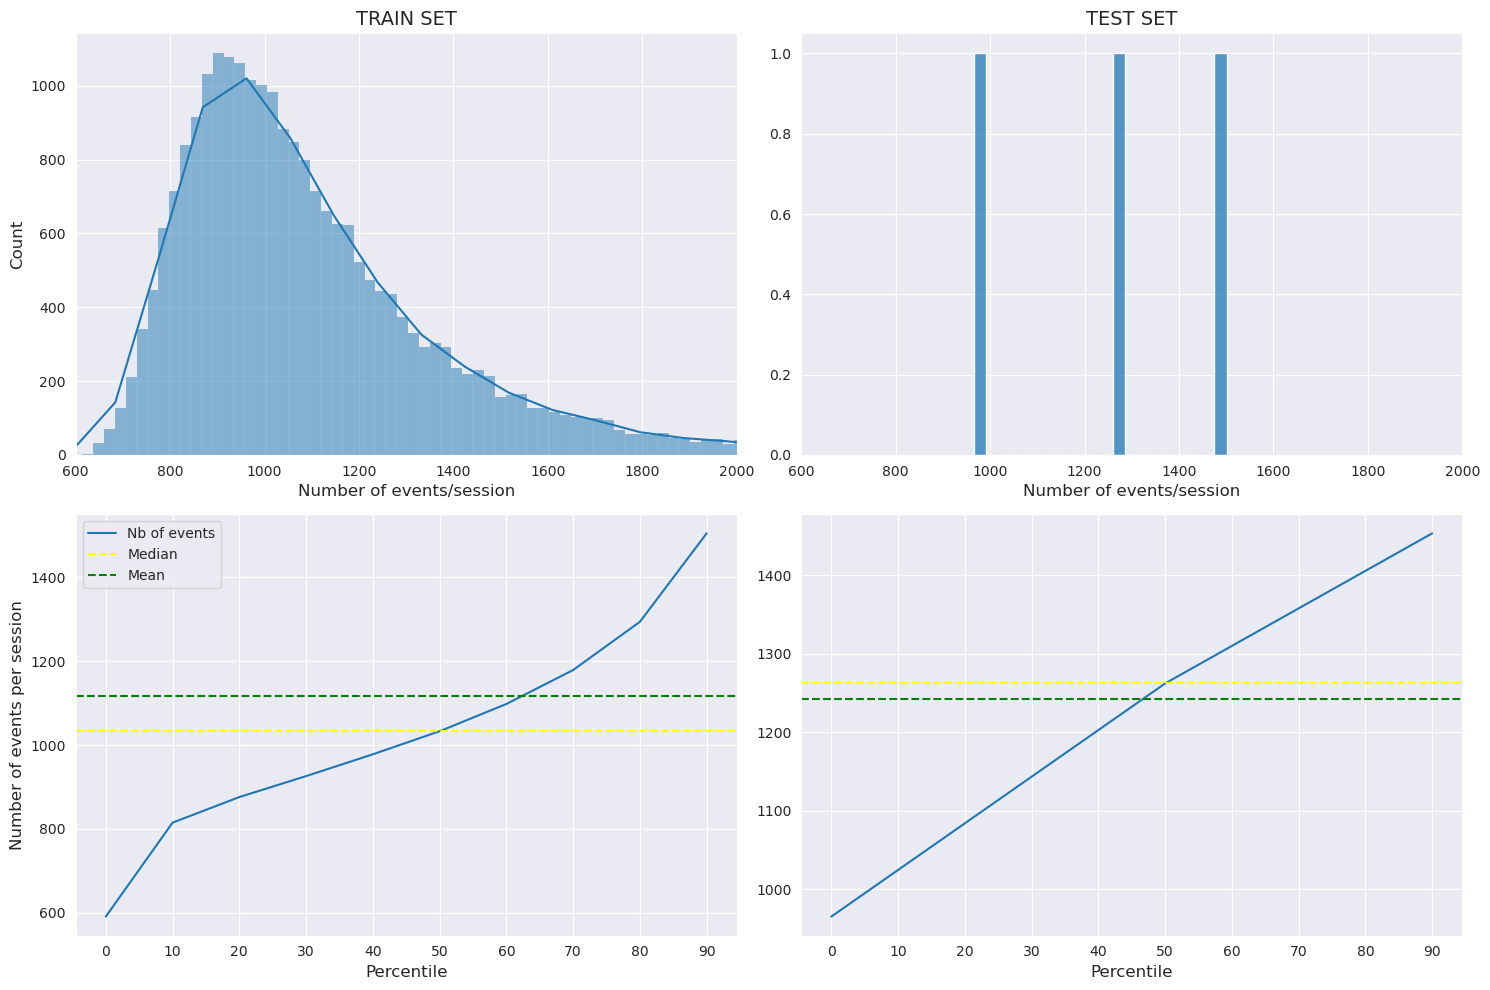

,TRAIN,TEST
Index,,
Nb of sessions,23562,3
Min nb of events,591,965
Max nb of events,19032,1501


In [24]:
train_events_per_session = student_train_data['session_id'].value_counts()
test_events_per_session = student_test_data['session_id'].value_counts()

train_percentiles, test_percentiles = [], []
xrange = range(0, 100, 10)
for i in xrange:
    train_perc = np.percentile(train_events_per_session, i)
    test_perc = np.percentile(test_events_per_session, i)
    train_percentiles.append(train_perc)
    test_percentiles.append(test_perc)
    
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.histplot(train_events_per_session.values, kde=True)
plt.xlabel("Number of events/session", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("TRAIN SET", fontsize=14)
plt.xlim(600, 2000)

plt.subplot(2, 2, 2)
sns.histplot(test_events_per_session.values, bins=20)
plt.xlabel("Number of events/session", fontsize=12), plt.ylabel("")
plt.title("TEST SET", fontsize=14)
plt.xlim(600, 2000)

plt.subplot(2, 2, 3)
plt.plot(xrange, train_percentiles)
plt.axhline(train_events_per_session.median(), color='yellow', ls='--')
plt.axhline(train_events_per_session.mean(), color='green', ls='--')
plt.xlabel("Percentile", fontsize=12)
plt.ylabel("Number of events per session", fontsize=12)
plt.xticks(xrange)
plt.legend(['Nb of events', 'Median', 'Mean'])

plt.subplot(2, 2, 4)
plt.plot(xrange, test_percentiles)
plt.axhline(test_events_per_session.median(), color='yellow', ls='--')
plt.axhline(test_events_per_session.mean(), color='green', ls='--')
plt.xlabel("Percentile", fontsize=12)
plt.xticks(xrange)

plt.tight_layout()
plt.show()

data = {"Index": ["Nb of sessions", "Min nb of events", "Max nb of events"],
        "TRAIN": [str(student_train_data['session_id'].nunique()),
                  str(train_events_per_session.min()),
                  str(train_events_per_session.max())],
        "TEST": [str(student_test_data['session_id'].nunique()),
                 str(test_events_per_session.min()),
                 str(test_events_per_session.max())]}
df = pd.DataFrame(data).set_index('Index')
df

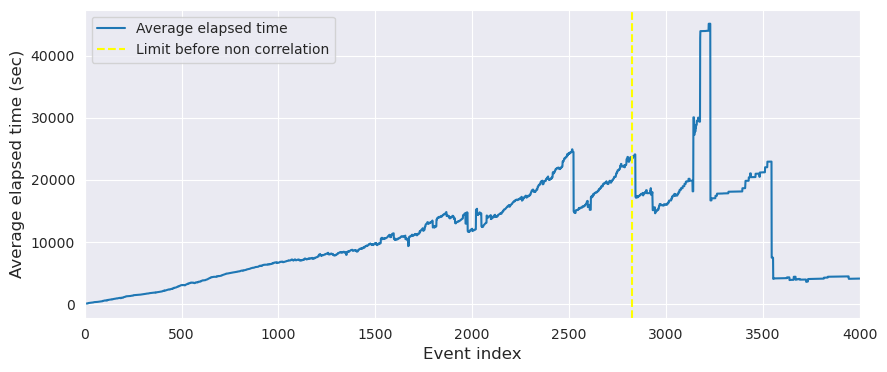

In [25]:
# Average the elapsed time in seconds for each index
avg_elapsed_time = student_train_data.groupby('index')['elapsed_time'].mean() / 1000

plt.figure(figsize=(10, 4))
plt.plot(avg_elapsed_time)
plt.axvline(2825, color='yellow', ls='--')
plt.xlabel("Event index", fontsize=12)
plt.ylabel("Average elapsed time (sec)", fontsize=12)
plt.xlim([0, 4000])
plt.legend(['Average elapsed time', 'Limit before non correlation'])

plt.show()

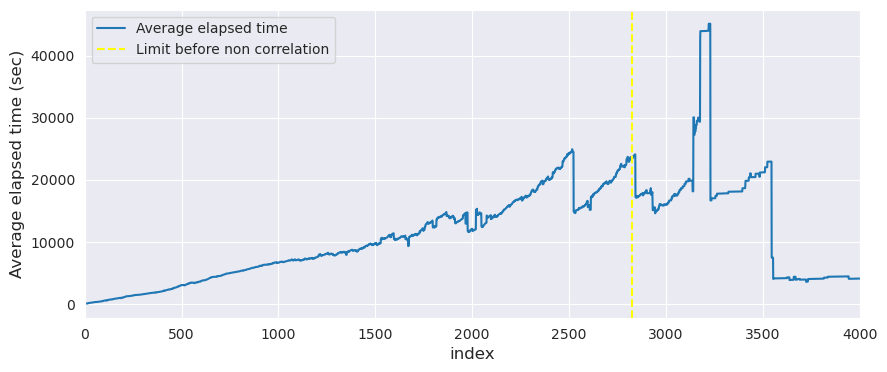

In [26]:
# Average the elapsed time in seconds for each index
avg_elapsed_time = student_train_data.groupby('index')['elapsed_time'].mean()/1000

plt.figure(figsize=(10, 4))
plt.plot(avg_elapsed_time)
plt.axvline(2825, color='yellow', ls='--')
plt.xlabel("index", fontsize=12)
plt.ylabel("Average elapsed time (sec)", fontsize=12)
plt.xlim([0, 4000])
plt.legend(['Average elapsed time', 'Limit before non correlation'])

plt.show()

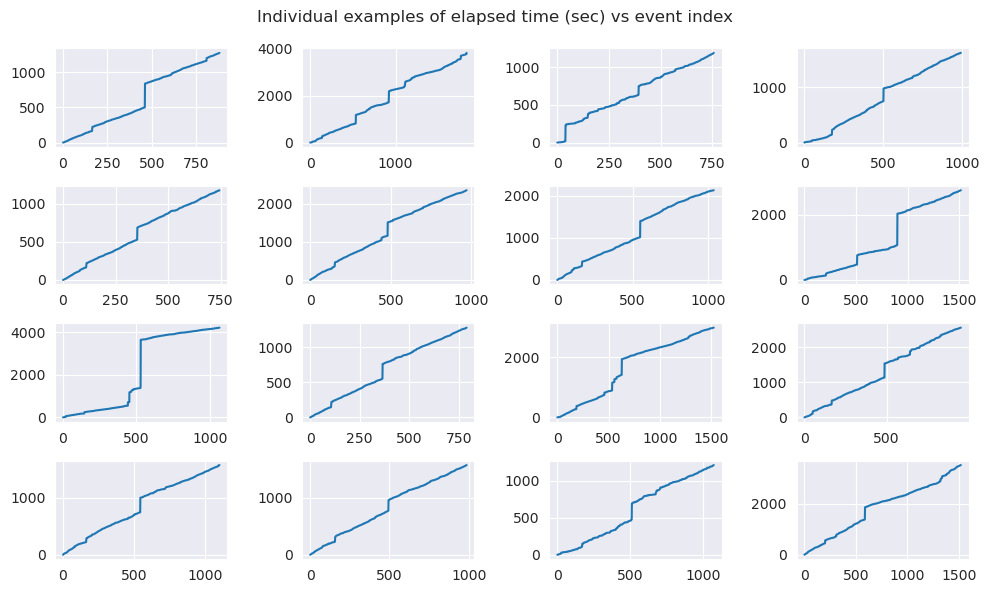

In [27]:

# Get the sessions in the dataframe
session_ids = np.array(student_train_data['session_id'].unique())

plt.figure(figsize=(10, 6))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    times = student_train_data[student_train_data['session_id'] == session_ids[i]]['elapsed_time']
    plt.plot(times.reset_index(drop=True) / 1000)
plt.suptitle("Individual examples of elapsed time (sec) vs event index")
plt.tight_layout()

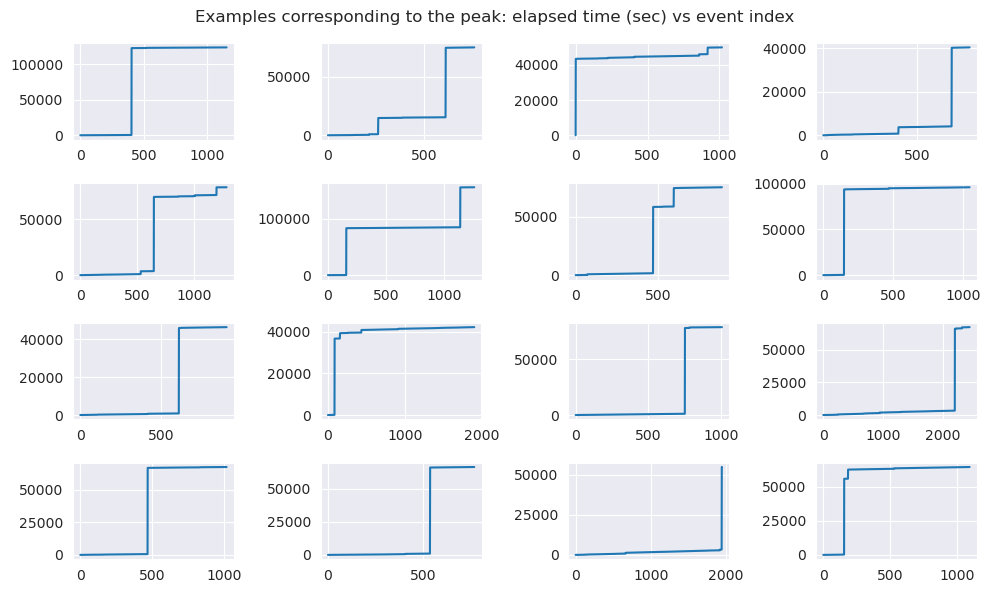

In [28]:

# Get the session ids corresponding to the peak
peak_session_ids = student_train_data[student_train_data['elapsed_time'] > 4e7]['session_id'].unique()

plt.figure(figsize=(10, 6))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    times = student_train_data[student_train_data['session_id'] == peak_session_ids[i]]['elapsed_time']
    plt.plot(times.reset_index(drop=True) / 1000)
plt.suptitle("Examples corresponding to the peak: elapsed time (sec) vs event index")
plt.tight_layout()
plt.show()



In [ ]:
#df = student_train_data[["index", "elapsed_time", "level"]]
#df.head()

In [ ]:
#df.to_csv('subset_data.csv', index=False)

In [ ]:
#df1 = student_train_data.iloc[1:1000, ]
#df1.head()

In [ ]:
#df1.to_csv('subset1_data.csv', index=False)

In [ ]:
# Randomly select 10% of the rows from the dataset
# sample_df = student_train_data.sample(frac=0.1, random_state=42)
# print(sample_df.shape)

In [30]:
# Set a random seed for reproducibility
np.random.seed(42)

# Randomly select 4% of the rows from the dataset
sample_df = student_train_data.sample(frac=0.04, random_state=42)

In [31]:
sample_df.shape

(1051878, 20)

### Use level group as X, default learning rate at 0.001
### 16-8-3 ReLU-ReLU-Softmax-Adam

In [ ]:

# Set a random seed for reproducibility
np.random.seed(42)


# Select the columns to use for training
X = sample_df[['elapsed_time']].values

# Normalize the input data
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Create a dictionary that maps each unique range to an integer
range_map = {'0-4': 0, '5-12': 1, '13-22': 2}

# Apply the mapping to the 'level_group' column
sample_df['level_group_int'] = sample_df['level_group'].map(range_map)

# Create the target variable
y = to_categorical(sample_df['level_group_int'].values, num_classes=3)

# Split the data into training, validation, and test sets
split1 = int(0.6 * len(X))
split2 = int(0.8 * len(X))
X_train, X_val, X_test = X[:split1], X[split1:split2], X[split2:]
y_train, y_val, y_test = y[:split1], y[split1:split2], y[split2:]

# Define the model architecture
model = Sequential()
model.add(Dense(16, input_shape=(1,), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Add early stopping callback
early_stop = EarlyStopping(monitor='val_accuracy', patience=8)

# Train the model
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stop])

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(X_val, y_val)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

# Evaluate the model on the training set
train_loss, train_acc = model.evaluate(X_train, y_train)
print("Training loss:", train_loss)
print("Training accuracy:", train_acc)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1) + 1

# Evaluate the model on the test set
test_acc = accuracy_score(y_test.argmax(axis=1) + 1, y_pred_labels)
print("Test accuracy:", test_acc)

Epoch 1/15
19723/19723 [==============================] - 43s 2ms/step - loss: 0.4670 - accuracy: 0.8218 - val_loss: 0.4189 - val_accuracy: 0.8340
Epoch 2/15
19723/19723 [==============================] - 41s 2ms/step - loss: 0.4045 - accuracy: 0.8415 - val_loss: 0.4098 - val_accuracy: 0.8423
Epoch 3/15
19723/19723 [==============================] - 42s 2ms/step - loss: 0.4035 - accuracy: 0.8418 - val_loss: 0.4164 - val_accuracy: 0.8378
Epoch 4/15
19723/19723 [==============================] - 38s 2ms/step - loss: 0.4025 - accuracy: 0.8422 - val_loss: 0.4013 - val_accuracy: 0.8428
Epoch 5/15
19723/19723 [==============================] - 38s 2ms/step - loss: 0.4018 - accuracy: 0.8422 - val_loss: 0.4105 - val_accuracy: 0.8385
Epoch 6/15
19723/19723 [==============================] - 39s 2ms/step - loss: 0.4014 - accuracy: 0.8423 - val_loss: 0.4077 - val_accuracy: 0.8395
Epoch 7/15
19723/19723 [==============================] - 40s 2ms/step - loss: 0.4012 - accuracy: 0.8423 - val_loss: 0

### 16-8-3 ReLU-ReLU-Softmax-Adam, learning rate 0.1

In [33]:
# Select the columns to use for training
X = sample_df[['elapsed_time']].values

# Normalize the input data
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Create a dictionary that maps each unique range to an integer
range_map = {'0-4': 0, '5-12': 1, '13-22': 2}

# Apply the mapping to the 'level_group' column
sample_df['level_group_int'] = sample_df['level_group'].map(range_map)

# Create the target variable
y = to_categorical(sample_df['level_group_int'].values, num_classes=3)

# Split the data into training, validation, and test sets
split1 = int(0.6 * len(X))
split2 = int(0.8 * len(X))
X_train, X_val, X_test = X[:split1], X[split1:split2], X[split2:]
y_train, y_val, y_test = y[:split1], y[split1:split2], y[split2:]

# Define the model architecture
model = Sequential()
model.add(Dense(16, input_shape=(1,), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.1)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Add early stopping callback
early_stop = EarlyStopping(monitor='val_accuracy', patience=8)

# Train the model
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stop])

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(X_val, y_val)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

# Evaluate the model on the training set
train_loss, train_acc = model.evaluate(X_train, y_train)
print("Training loss:", train_loss)
print("Training accuracy:", train_acc)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1) + 1

# Evaluate the model on the test set
test_acc = accuracy_score(y_test.argmax(axis=1) + 1, y_pred_labels)
print("Test accuracy:", test_acc)

Epoch 1/15
19723/19723 [==============================] - 39s 2ms/step - loss: 0.4768 - accuracy: 0.8229 - val_loss: 0.4596 - val_accuracy: 0.8373
Epoch 2/15
19723/19723 [==============================] - 43s 2ms/step - loss: 0.4650 - accuracy: 0.8310 - val_loss: 0.4704 - val_accuracy: 0.8339
Epoch 3/15
19723/19723 [==============================] - 43s 2ms/step - loss: 0.4645 - accuracy: 0.8314 - val_loss: 0.5346 - val_accuracy: 0.8108
Epoch 4/15
19723/19723 [==============================] - 38s 2ms/step - loss: 0.4636 - accuracy: 0.8318 - val_loss: 0.4534 - val_accuracy: 0.8424
Epoch 5/15
19723/19723 [==============================] - 42s 2ms/step - loss: 0.4636 - accuracy: 0.8321 - val_loss: 0.4498 - val_accuracy: 0.8416
Epoch 6/15
19723/19723 [==============================] - 40s 2ms/step - loss: 0.4623 - accuracy: 0.8326 - val_loss: 0.4536 - val_accuracy: 0.8424
Epoch 7/15
19723/19723 [==============================] - 40s 2ms/step - loss: 0.4633 - accuracy: 0.8323 - val_loss: 0

### 16-8-3 ReLU-ReLU-Softmax-Adam, learning rate 0.01

In [ ]:
# Select the columns to use for training
X = sample_df[['elapsed_time']].values

# Normalize the input data
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Create a dictionary that maps each unique range to an integer
range_map = {'0-4': 0, '5-12': 1, '13-22': 2}

# Apply the mapping to the 'level_group' column
sample_df['level_group_int'] = sample_df['level_group'].map(range_map)

# Create the target variable
y = to_categorical(sample_df['level_group_int'].values, num_classes=3)

# Split the data into training, validation, and test sets
split1 = int(0.6 * len(X))
split2 = int(0.8 * len(X))
X_train, X_val, X_test = X[:split1], X[split1:split2], X[split2:]
y_train, y_val, y_test = y[:split1], y[split1:split2], y[split2:]

# Define the model architecture
model = Sequential()
model.add(Dense(16, input_shape=(1,), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Add early stopping callback
early_stop = EarlyStopping(monitor='val_accuracy', patience=8)

# Train the model
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stop])

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(X_val, y_val)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

# Evaluate the model on the training set
train_loss, train_acc = model.evaluate(X_train, y_train)
print("Training loss:", train_loss)
print("Training accuracy:", train_acc)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1) + 1

# Evaluate the model on the test set
test_acc = accuracy_score(y_test.argmax(axis=1) + 1, y_pred_labels)
print("Test accuracy:", test_acc)

### 16-8-3 ReLU-ReLU-Softmax-Adam, learning rate 0.0001

In [ ]:
# Select the columns to use for training
X = sample_df[['elapsed_time']].values

# Normalize the input data
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Create a dictionary that maps each unique range to an integer
range_map = {'0-4': 0, '5-12': 1, '13-22': 2}

# Apply the mapping to the 'level_group' column
sample_df['level_group_int'] = sample_df['level_group'].map(range_map)

# Create the target variable
y = to_categorical(sample_df['level_group_int'].values, num_classes=3)

# Split the data into training, validation, and test sets
split1 = int(0.6 * len(X))
split2 = int(0.8 * len(X))
X_train, X_val, X_test = X[:split1], X[split1:split2], X[split2:]
y_train, y_val, y_test = y[:split1], y[split1:split2], y[split2:]

# Define the model architecture
model = Sequential()
model.add(Dense(16, input_shape=(1,), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Add early stopping callback
early_stop = EarlyStopping(monitor='val_accuracy', patience=8)

# Train the model
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stop])

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(X_val, y_val)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

# Evaluate the model on the training set
train_loss, train_acc = model.evaluate(X_train, y_train)
print("Training loss:", train_loss)
print("Training accuracy:", train_acc)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1) + 1

# Evaluate the model on the test set
test_acc = accuracy_score(y_test.argmax(axis=1) + 1, y_pred_labels)
print("Test accuracy:", test_acc)

### 32-16-8-3 ReLU-ReLU-ReLU-Softmax-Adam, learning rate 0.001

In [ ]:
# Select the columns to use for training
X = sample_df[['elapsed_time']].values

# Normalize the input data
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Create a dictionary that maps each unique range to an integer
range_map = {'0-4': 0, '5-12': 1, '13-22': 2}

# Apply the mapping to the 'level_group' column
sample_df['level_group_int'] = sample_df['level_group'].map(range_map)

# Create the target variable
y = to_categorical(sample_df['level_group_int'].values, num_classes=3)

# Split the data into training, validation, and test sets
split1 = int(0.6 * len(X))
split2 = int(0.8 * len(X))
X_train, X_val, X_test = X[:split1], X[split1:split2], X[split2:]
y_train, y_val, y_test = y[:split1], y[split1:split2], y[split2:]

# Define the model architecture
model = Sequential()
model.add(Dense(32, input_shape=(1,), activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Add early stopping callback
early_stop = EarlyStopping(monitor='val_accuracy', patience=8)

# Train the model
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stop])

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(X_val, y_val)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

# Evaluate the model on the training set
train_loss, train_acc = model.evaluate(X_train, y_train)
print("Training loss:", train_loss)
print("Training accuracy:", train_acc)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1) + 1

# Evaluate the model on the test set
test_acc = accuracy_score(y_test.argmax(axis=1) + 1, y_pred_labels)
print("Test accuracy:", test_acc)

### 16-8-3 ReLU-ReLU-SGD, learning rate 0.001

In [ ]:
# Select the columns to use for training
X = sample_df[['elapsed_time']].values

# Normalize the input data
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Create a dictionary that maps each unique range to an integer
range_map = {'0-4': 0, '5-12': 1, '13-22': 2}

# Apply the mapping to the 'level_group' column
sample_df['level_group_int'] = sample_df['level_group'].map(range_map)

# Create the target variable
y = to_categorical(sample_df['level_group_int'].values, num_classes=3)

# Split the data into training, validation, and test sets
split1 = int(0.6 * len(X))
split2 = int(0.8 * len(X))
X_train, X_val, X_test = X[:split1], X[split1:split2], X[split2:]
y_train, y_val, y_test = y[:split1], y[split1:split2], y[split2:]

# Define the model architecture
model = Sequential()
model.add(Dense(16, input_shape=(1,), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compile the model
optimizer = SGD(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Add early stopping callback
early_stop = EarlyStopping(monitor='val_accuracy', patience=8)

# Train the model
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stop])

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(X_val, y_val)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

# Evaluate the model on the training set
train_loss, train_acc = model.evaluate(X_train, y_train)
print("Training loss:", train_loss)
print("Training accuracy:", train_acc)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1) + 1

# Evaluate the model on the test set
test_acc = accuracy_score(y_test.argmax(axis=1) + 1, y_pred_labels)
print("Test accuracy:", test_acc)

### 32-16-8-4-3 ReLU-ReLU-ReLU-ReLU-Softmax-Adam 0.001

In [ ]:
# Select the columns to use for training
X = sample_df[['elapsed_time']].values

# Normalize the input data
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Create a dictionary that maps each unique range to an integer
range_map = {'0-4': 0, '5-12': 1, '13-22': 2}

# Apply the mapping to the 'level_group' column
sample_df['level_group_int'] = sample_df['level_group'].map(range_map)

# Create the target variable
y = to_categorical(sample_df['level_group_int'].values, num_classes=3)

# Split the data into training, validation, and test sets
split1 = int(0.6 * len(X))
split2 = int(0.8 * len(X))
X_train, X_val, X_test = X[:split1], X[split1:split2], X[split2:]
y_train, y_val, y_test = y[:split1], y[split1:split2], y[split2:]

# Define the model architecture
model = Sequential()
model.add(Dense(32, input_shape=(1,), activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Add early stopping callback
early_stop = EarlyStopping(monitor='val_accuracy', patience=8)

# Train the model
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stop])

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(X_val, y_val)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

# Evaluate the model on the training set
train_loss, train_acc = model.evaluate(X_train, y_train)
print("Training loss:", train_loss)
print("Training accuracy:", train_acc)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1) + 1

# Evaluate the model on the test set
test_acc = accuracy_score(y_test.argmax(axis=1) + 1, y_pred_labels)
print("Test accuracy:", test_acc)

In [ ]:
print(abc)

In [ ]:

# # Load the train dataset
# train_df = pd.read_csv('train.csv')

# Select the columns to use for training
X = student_train_data[['elapsed_time', 'level']].values

# Normalize the input data
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Create the target variable
y = student_train_data['level_group'].values

# Define the model architecture
model = Sequential()
model.add(Dense(32, input_dim=2, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)


In [ ]:
train_data = student_train_data[selected_features]
train_data.shape

In [ ]:
getcolumns()

In [ ]:
# Create a new dataframe by sampling the original dataframe
sampled_train_data = train_data.sample(n=13148473, replace=False, random_state=80)

In [ ]:
sampled_train_data.columns

In [ ]:
df = student_train_data[['elapsed_time', 'level']]

In [ ]:
# Scale data for neural network
scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [ ]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sampled_train_data.iloc[:,:-1], sampled_train_data.iloc[:,-1], test_size=0.3, random_state=80)


In [ ]:
# Random sampling
samplesize = int(0.60 * len(sample_train_data))
np.random.seed(80)
index = np.random.choice(np.arange(len(sample_train_data)), size=samplesize, replace=False)

In [ ]:


# Create training and test set
datatrain = student_train_data.iloc[index]
datatest = student_train_data.iloc[np.delete(np.arange(len(data)), index)]

# Display the results
print("Training set:")
print(datatrain.head())
print("Test set:")
print(datatest.head())
